In [0]:
import keras
from keras_preprocessing import text
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, Input, Conv1D, MaxPooling1D, LSTM, Dropout
from keras import backend as K
import keras.initializers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import zipfile
import csv,io
import nltk
import string
from string import punctuation
import re
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [0]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Constants

EMBED_SIZE=100
VOCAB_SIZE = 10000
INDEX_FROM = 2
#MAXIMUM_LENGTH = 500
TRAIN_SPLIT = 0.5

In [0]:
# Get Data

!wget http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4a-english.zip

--2019-02-20 16:07:16--  http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4a-english.zip
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1670639 (1.6M) [application/zip]
Saving to: ‘4a-english.zip’

4a-english.zip      100%[===================>]   1.59M  1.68MB/s    in 1.0s    

2019-02-20 16:07:18 (1.68 MB/s) - ‘4a-english.zip’ saved [1670639/1670639]



In [0]:
# Extract Training Data File

def extract_without_folder(arc_name, full_item_name, folder):
    with zipfile.ZipFile(arc_name) as zf:
        file_data = zf.read(full_item_name)
    with open(os.path.join(folder, os.path.basename(full_item_name)), "wb") as fout:
        fout.write(file_data)

path_to_zip_file = '4a-english.zip'
directory_to_extract_to = os.getcwd()  
extract_without_folder(path_to_zip_file,'4A-English/SemEval2017-task4-dev.subtask-A.english.INPUT.txt',directory_to_extract_to )

In [0]:
#Sanity Check: Read and Display data
text_file = open("SemEval2017-task4-dev.subtask-A.english.INPUT.txt", "r")
corpus = text_file.read()
print(len(corpus))
print(corpus[:1000])

2995085
619950566786113536	neutral	"Picturehouse's, Pink Floyd's, 'Roger Waters: The Walll - opening 29 Sept is now making waves. Watch the trailer on Rolling Stone - look..."	
619969366986235905	neutral	Order Go Set a Watchman in store or through our website before Tuesday and get it half price! #GSAW @GSAWatchmanBook https://t.co/KET6EGD1an	
619971047195045888	negative	"If these runway renovations at the airport prevent me from seeing Taylor Swift on Monday, Bad Blood will have a new meaning."	
619974445185302528	neutral	"If you could ask an onstage interview question at Miss USA tomorrow, what would it be?"	
619987808317407232	positive	A portion of book sales from our Harper Lee/Go Set a Watchman release party on Mon. 7/13 will support @CAP_Tulsa and the great work they do.	
619994586182619136	positive	"Excited to read ""Go Set a Watchman"" on Tuesday.  But can it possibly live up to ""To Kill a Mockingbird?""  Any opinions?"	
619998879447162881	positive	"Watching Miss USA tomorrow 

In [0]:
#Preprocessing 1 - Create tweet data and labels

labels = []
tweets = []
f = csv.reader(io.StringIO(corpus), delimiter='\t')
for row in f:
  labels.append(row[1])
  tweets.append(row[2])
    #print(row[1], row[2])

In [0]:
remove_terms = punctuation + '0123456789'

In [0]:
def normalize_document(doc):
    stop_words = nltk.corpus.stopwords.words('english')
    wpt = nltk.WordPunctTokenizer()


    # lower case and remove special characters\whitespaces

    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)

    doc = doc.lower()

    doc = doc.strip()

    # tokenize document

    tokens = wpt.tokenize(doc)

    # filter stopwords out of document

    filtered_tokens = [token for token in tokens if token not in stop_words]

    # re-create document from filtered tokens

    doc = ' '.join(filtered_tokens)

    return doc
 

In [0]:
normalize_corpus = np.vectorize(normalize_document)
normalized_corpus = [[word.lower() for word in sent if word not in remove_terms] for sent in tweets]

normalized_corpus = [''.join(tok_sent) for tok_sent in normalized_corpus]

#normalized_corpus = filter(None, normalize_corpus(normalized_corpus))
#normalized_corpus = list(normalized_corpus)
#normalized_corpus = [tok_sent for tok_sent in normalized_corpus if len(tok_sent.split()) > 2]

normalized_corpus = list(normalized_corpus)

In [0]:
print(tweets[0])
print(normalized_corpus[0])

Picturehouse's, Pink Floyd's, 'Roger Waters: The Walll - opening 29 Sept is now making waves. Watch the trailer on Rolling Stone - look...
picturehouses pink floyds roger waters the walll  opening  sept is now making waves watch the trailer on rolling stone  look


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_corpus)
sequences = tokenizer.texts_to_sequences(normalized_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 37028 unique tokens.


In [0]:
def lengths(x):
    if isinstance(x,list):
        yield len(x)
        for y in x:
            yield from lengths(y)

MAXIMUM_LENGTH = max([len(x) for x in normalized_corpus])

In [0]:
from keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAXIMUM_LENGTH)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20632, 144)


In [0]:
print(len(tweets))
print(len(labels))
print(len(data))
print(len(sequences))
print(len(normalized_corpus))
print(data[0])

20632
20632
20632
20632
20632
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1665 3032 7939    1  911  445    9   65  591 6255  122    1 1191
    7  405  422  331]


In [0]:
os.listdir()

['.config',
 'SemEval2017-task4-dev.subtask-A.english.INPUT.txt',
 '4a-english.zip',
 'sample_data']

In [0]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]


In [0]:


nb_validation_samples = int(TRAIN_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


print(nb_validation_samples)
print(len(x_train))
print(len(y_train))

print(len(x_val))
print(len(y_val))

10316
10316
10316
10316
10316


In [0]:
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

In [0]:
# Get Pre-trained Embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-02-20 16:08:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-02-20 16:08:02--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  10.1MB/s    in 75s     

2019-02-20 16:09:17 (11.0 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [0]:
#Unzip the embedding files

path_to_zip_file = 'glove.6B.zip'
directory_to_extract_to = os.getcwd()  

zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()

In [0]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAXIMUM_LENGTH,
                            trainable=False)

In [0]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [0]:
# Model with Embedding Layer
model = Sequential()

#We change our first layer in model1 to an Embedding layer
model.add(keras.layers.Embedding(VOCAB_SIZE,16))


#The second layer is to compute average on all word vectors 
model.add(GlobalAveragePooling1DMasked())



#The output vector is piped through a fully-connected layer
model.add(keras.layers.Dense(16, activation=K.relu))



#The last layer is connected with a single output node with the sigmoid activation function
model.add(keras.layers.Dense(3, activation=K.sigmoid))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_mas (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 160,323
Trainable params: 160,323
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(x_train,
                    np.array(y_train),
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, np.array(y_val)),
                    verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 2s 131us/step - loss: 1.0556 - acc: 0.4869 - val_loss: 0.9949 - val_acc: 0.4650
Epoch 2/3
16505/16505 [==============================] - 1s 73us/step - loss: 1.0009 - acc: 0.5103 - val_loss: 0.9986 - val_acc: 0.4650
Epoch 3/3
16505/16505 [==============================] - 1s 64us/step - loss: 0.9972 - acc: 0.5103 - val_loss: 0.9958 - val_acc: 0.4650


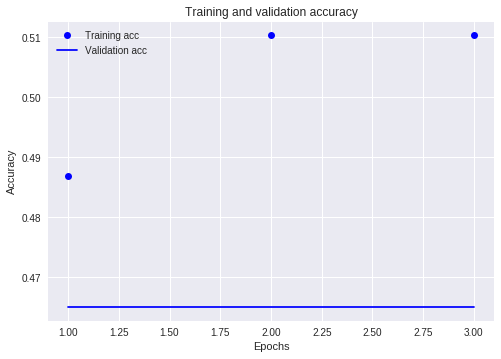

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#print(x_train[0])
#print(y_train[0])
print(x_val[0])
print(y_val[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  444  451 1982    9   60
  319 1982 5376    2    1   27  172]
[0 1 0]


In [0]:
model_lstm = Sequential() 

model_lstm.add(embedding_layer)

#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm.add(LSTM(100)) 
model_lstm.add(Dense(3, activation='softmax')) 
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 


In [0]:
print(model_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 144, 100)          3702900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 3,783,603
Trainable params: 80,703
Non-trainable params: 3,702,900
_________________________________________________________________
None


In [0]:
history = model_lstm.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 10316 samples, validate on 10316 samples
Epoch 1/3
10316/10316 [==============================] - 49s 5ms/step - loss: 0.7433 - acc: 0.6543 - val_loss: 0.8158 - val_acc: 0.6185
Epoch 2/3
10316/10316 [==============================] - 49s 5ms/step - loss: 0.7144 - acc: 0.6748 - val_loss: 0.8128 - val_acc: 0.6201
Epoch 3/3
10316/10316 [==============================] - 51s 5ms/step - loss: 0.6934 - acc: 0.6866 - val_loss: 0.8096 - val_acc: 0.6283


In [0]:
results_lstm = model_lstm.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm[0], 'Test Accuracy: ',results_lstm[1])

10316/10316 [==============================] - 11s 1ms/step
Test Loss:  0.8095827415822411 Test Accuracy:  0.6283443195267951


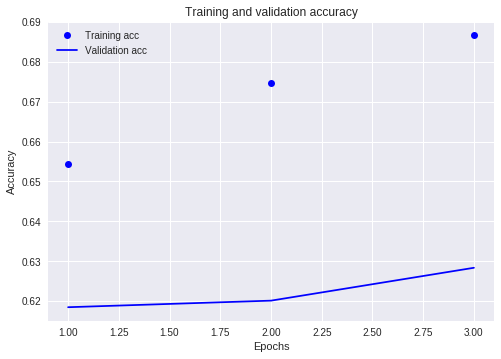

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm2 = Sequential() 

model_lstm2.add(embedding_layer)
model_lstm2.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm2.add(LSTM(100)) 
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(3, activation='softmax')) 
model_lstm2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm2.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 144, 100)          3702900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 303       
Total params: 3,783,603
Trainable params: 80,703
Non-trainable params: 3,702,900
_________________________________________________________________


In [0]:
history_lstm2 = model_lstm2.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 10316 samples, validate on 10316 samples
Epoch 1/3
10316/10316 [==============================] - 51s 5ms/step - loss: 0.9588 - acc: 0.5197 - val_loss: 0.8945 - val_acc: 0.5675
Epoch 2/3
10316/10316 [==============================] - 50s 5ms/step - loss: 0.8801 - acc: 0.5731 - val_loss: 0.8901 - val_acc: 0.5644
Epoch 3/3
10316/10316 [==============================] - 50s 5ms/step - loss: 0.8562 - acc: 0.5867 - val_loss: 0.8895 - val_acc: 0.5845


In [0]:
results_lstm2 = model_lstm2.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm2[0], 'Test Accuracy: ',results_lstm2[1])

10316/10316 [==============================] - 11s 1ms/step
Test Loss:  0.8894706201349963 Test Accuracy:  0.5845288871424565


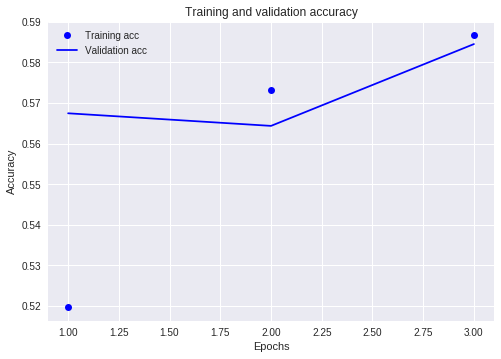

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm2 = history_lstm2.history

acc = history_dict_lstm2['acc']
val_acc = history_dict_lstm2['val_acc']
loss = history_dict_lstm2['loss']
val_loss = history_dict_lstm2['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm3 = Sequential() 

model_lstm3.add(embedding_layer)
model_lstm3.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm3.add(LSTM(100)) 
model_lstm3.add(Dropout(0.5))
model_lstm3.add(Dense(3, activation='softmax')) 
model_lstm3.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 144, 100)          3702900   
_________________________________________________________________
dropout_3 (Dropout)          (None, 144, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 3,783,603
Trainable params: 80,703
Non-trainable params: 3,702,900
_________________________________________________________________


In [0]:
history_lstm3 = model_lstm3.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 10316 samples, validate on 10316 samples
Epoch 1/6
10316/10316 [==============================] - 53s 5ms/step - loss: 0.9652 - acc: 0.5070 - val_loss: 1.0727 - val_acc: 0.4490
Epoch 2/6
10316/10316 [==============================] - 52s 5ms/step - loss: 0.8810 - acc: 0.5704 - val_loss: 0.9499 - val_acc: 0.5554
Epoch 3/6
10316/10316 [==============================] - 52s 5ms/step - loss: 0.8594 - acc: 0.5848 - val_loss: 0.8717 - val_acc: 0.5870
Epoch 4/6
10316/10316 [==============================] - 51s 5ms/step - loss: 0.8318 - acc: 0.6010 - val_loss: 0.8710 - val_acc: 0.5827
Epoch 5/6
10316/10316 [==============================] - 51s 5ms/step - loss: 0.8345 - acc: 0.6035 - val_loss: 0.8484 - val_acc: 0.6024
Epoch 6/6
10316/10316 [==============================] - 50s 5ms/step - loss: 0.8173 - acc: 0.6085 - val_loss: 0.8551 - val_acc: 0.6022


In [0]:
results_lstm3 = model_lstm3.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm3[0], 'Test Accuracy: ',results_lstm3[1])

10316/10316 [==============================] - 11s 1ms/step
Test Loss:  0.8550839383225887 Test Accuracy:  0.6021713842805757


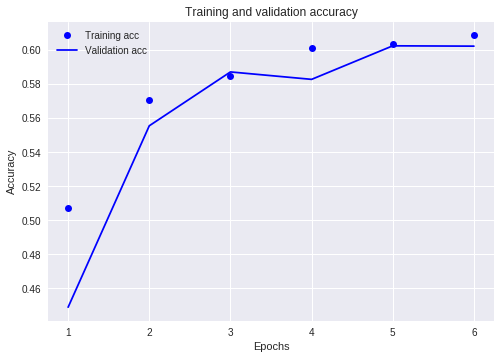

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm3 = history_lstm3.history

acc = history_dict_lstm3['acc']
val_acc = history_dict_lstm3['val_acc']
loss = history_dict_lstm3['loss']
val_loss = history_dict_lstm3['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm4 = Sequential() 

model_lstm4.add(embedding_layer)
model_lstm4.add(Dropout(0.3))

model_lstm4.add(LSTM(100)) 
model_lstm4.add(Dropout(0.3))
model_lstm4.add(Dense(3, activation='softmax')) 
model_lstm4.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm4.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 144, 100)          3702900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 3,783,603
Trainable params: 80,703
Non-trainable params: 3,702,900
______

In [0]:
history_lstm4 = model_lstm4.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 10316 samples, validate on 10316 samples
Epoch 1/6
10316/10316 [==============================] - 53s 5ms/step - loss: 0.9206 - acc: 0.5478 - val_loss: 0.8763 - val_acc: 0.5693
Epoch 2/6
10316/10316 [==============================] - 52s 5ms/step - loss: 0.8393 - acc: 0.5989 - val_loss: 0.8971 - val_acc: 0.5778
Epoch 3/6
10316/10316 [==============================] - 52s 5ms/step - loss: 0.8187 - acc: 0.6103 - val_loss: 0.8726 - val_acc: 0.5790
Epoch 4/6
10316/10316 [==============================] - 52s 5ms/step - loss: 0.7970 - acc: 0.6207 - val_loss: 0.9045 - val_acc: 0.5641
Epoch 5/6
10316/10316 [==============================] - 52s 5ms/step - loss: 0.7890 - acc: 0.6278 - val_loss: 0.8307 - val_acc: 0.6081
Epoch 6/6
10316/10316 [==============================] - 52s 5ms/step - loss: 0.7666 - acc: 0.6380 - val_loss: 0.8250 - val_acc: 0.6143


In [0]:
results_lstm4 = model_lstm4.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm4[0], 'Test Accuracy: ',results_lstm4[1])

10316/10316 [==============================] - 11s 1ms/step
Test Loss:  0.8249738464849131 Test Accuracy:  0.6142884839316032


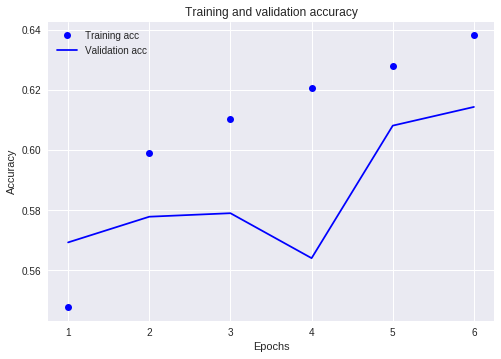

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm4 = history_lstm4.history

acc = history_dict_lstm4['acc']
val_acc = history_dict_lstm4['val_acc']
loss = history_dict_lstm4['loss']
val_loss = history_dict_lstm4['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm4.save('Task4_Eng_lstm4.h5')

In [0]:
os.listdir()

['.config',
 'SemEval2017-task4-dev.subtask-A.english.INPUT.txt',
 'glove.6B.300d.txt',
 'glove.6B.50d.txt',
 'glove.6B.zip',
 '4a-english.zip',
 'Task4_Eng_lstm4.h5',
 'glove.6B.200d.txt',
 'glove.6B.100d.txt',
 'sample_data']

In [0]:
!wget https://qmplus.qmul.ac.uk/pluginfile.php/1555056/mod_folder/content/0/semeval2017-task4-test.zip

--2019-02-20 10:57:52--  https://qmplus.qmul.ac.uk/pluginfile.php/1555056/mod_folder/content/0/semeval2017-task4-test.zip
Resolving qmplus.qmul.ac.uk (qmplus.qmul.ac.uk)... 128.86.140.87
Connecting to qmplus.qmul.ac.uk (qmplus.qmul.ac.uk)|128.86.140.87|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://qmplus.qmul.ac.uk/enrol/index.php?id=10574 [following]
--2019-02-20 10:57:53--  https://qmplus.qmul.ac.uk/enrol/index.php?id=10574
Connecting to qmplus.qmul.ac.uk (qmplus.qmul.ac.uk)|128.86.140.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘semeval2017-task4-test.zip’

semeval2017-task4-t     [  <=>               ]  64.54K   244KB/s    in 0.3s    

2019-02-20 10:57:55 (244 KB/s) - ‘semeval2017-task4-test.zip’ saved [66086]



In [0]:
text_file = open("SemEval2017-task4-test.subtask-A.english.txt", "r")
test_corpus = text_file.read()
print(len(test_corpus))
print(test_corpus[:1000])

1694351
801989080477154944	neutral	#ArianaGrande Ari By Ariana Grande 80% Full https://t.co/ylhCMETHHW #Singer #Actress https://t.co/lTrb1JQiEA
801989272341453952	positive	Ariana Grande KIIS FM Yours Truly CD listening party in Burbank https://t.co/ClQIcx8Z6V #ArianaGrande
801990978424962944	positive	Ariana Grande White House Easter Egg Roll in Washington https://t.co/jdjL9swWM8 #ArianaGrande
801996232553963008	positive	#CD #Musics Ariana Grande Sweet Like Candy 3.4 oz 100 ML Sealed In Box 100% Authenic New https://t.co/oFmp0bOvZy… https://t.co/WIHLch9KtK
801998343442407040	neutral	SIDE TO SIDE 😘 @arianagrande #sidetoside #arianagrande #musically #comunidadgay #lgbt🌈  #LOTB… https://t.co/tEd8rftAxV
802001659970744064	positive	Hairspray Live! Previews at the Macy's Thanksgiving Day Parade! https://t.co/GaFTqInolL #arianagrande #televisionnbc
802003380973568000	positive	#LindsayLohan Is ‘Feeling Thankful’ After Blasting #ArianaGrande For Wearing ‘#TooMuch… https://t.co/Acf8ogvPxd https:/

In [0]:
labels = []
tweets = []
f = csv.reader(io.StringIO(test_corpus), delimiter='\t')
for row in f:
  labels.append(row[1])
  tweets.append(row[2])

normalize_corpus = np.vectorize(normalize_document)
normalized_corpus = [[word.lower() for word in sent if word not in remove_terms] for sent in tweets]

normalized_corpus = [''.join(tok_sent) for tok_sent in normalized_corpus]

#normalized_corpus = filter(None, normalize_corpus(normalized_corpus))
#normalized_corpus = list(normalized_corpus)
#normalized_corpus = [tok_sent for tok_sent in normalized_corpus if len(tok_sent.split()) > 2]

normalized_corpus = list(normalized_corpus)




tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_corpus)
sequences = tokenizer.texts_to_sequences(normalized_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))








/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 34617 unique tokens.


In [0]:
data = pad_sequences(sequences, maxlen=MAXIMUM_LENGTH)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)


# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]
#labels = labels[indices]


nb_validation_samples = int(TRAIN_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


print(nb_validation_samples)
print(len(x_train))
print(len(y_train))

print(len(x_val))
print(len(y_val))

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

Shape of data tensor: (11906, 144)
5953
5953
5953
5953
5953


In [0]:
nb_validation_samples = int(TRAIN_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

print(nb_validation_samples)
print(len(x_train))
print(len(y_train))

print(len(x_val))
print(len(y_val))
print(y_val[0])

5953
5953
5953
5953
5953
[1 0 0]


In [0]:
test_lstm4 = model_lstm4.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm4[0], 'Test Accuracy: ',results_lstm4[1])

5953/5953 [==============================] - 6s 1ms/step
Test Loss:  0.8249738464849131 Test Accuracy:  0.6142884839316032
